In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
print(os.listdir("."))


['change_pointorder.py', 'IoU_3d.ipynb', '.vscode', 'M_requirements.txt', 'models', '.ipynb_checkpoints', 'README.md', 'images', 'csv', '.gitignore', 'check_point_order.py', 'debug_pnp.py', 'labels_pnp', 'NOTICE', 'readme', 'change_background.ipynb', 'bad_list.txt', 'test_pointorder.ipynb', 'data', 'requirements.txt', 'src', 'eval.py', 'test_pnp.ipynb', 'demo', 'exp', 'LICENSE.md', '.git']


In [3]:
data_root="data/outf_all/"
img_root="/apollo/mle/Datasets/boxes/"

[[2994.3861572394085, 2013.263303498987], [2946.293580185039, 1588.119440281891], [4456.977078834853, 1639.575493524887], [3627.375241104635, 1087.0095486384232], [2027.9998719648906, 763.9999932213896], [2051.3491517861553, 3393.210587802422], [3627.1830324551242, 2831.29014339846], [3015.7551238423957, 2202.1674041106107], [1470.2621137231506, 2402.6726506657124]]


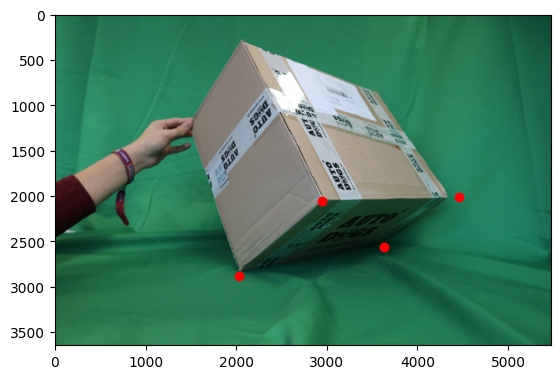

In [4]:
with open(data_root+"ford/validation.json", 'r') as f:
    data=json.load(f)
    

test_dict=data[39]
m_img=plt.imread(img_root+test_dict["image_name"])
h, w, c=m_img.shape
plt.imshow(m_img)


m_points=test_dict["points"]
print(m_points)
for p in m_points[1:5]:
    plt.plot(p[0],h-p[1], 'ro')
plt.show()
    


In [5]:
with open(data_root+"cereal/cereal_box_batch-1_6/00255.json", 'r') as f:
    data=json.load(f)
o_points=data["objects"][0]["projected_cuboid"]
print(o_points)
o_img=plt.imread(data_root+"cereal/cereal_box_batch-1_6/00255.png")

[[297, 375], [149, 618], [212, 677], [62, 132], [149, 144], [358, 471], [420, 503], [373, 101], [460, 105]]


# order points in the json of objectron: 
plan faurthes away from camera: from bottom left - right- up left- up right 
same order for the other plain

/tmp/ipykernel_18815/4094192510.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(p[0], p[1], cmap='b')


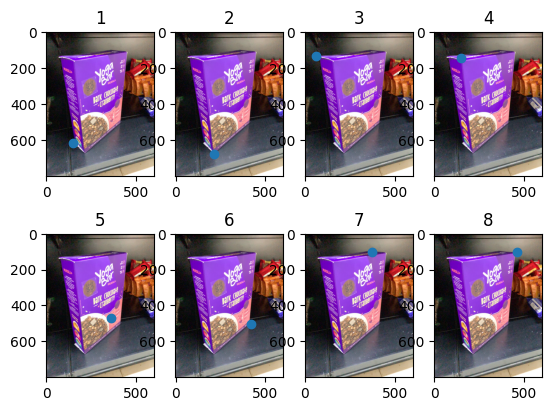

In [6]:

for i, p in enumerate(o_points[1:]):
     plt.subplot(2,4,i+1)
     plt.imshow(o_img)
     plt.scatter(p[0], p[1], cmap='b')
     plt.title(f"{i+1}")
plt.show()

In [7]:
# idee oppervlak:
front=[1,2,3,4]
back= [5,6,7,8]
left = [1,4,8,5] # eerste en laatste 
right= [2,3, 7, 6] # 2 middelste 
top=[1,2,6,5] # eerste 2 
bottem=[3,4,8,7] # laatste 2 
vlakken=[front, back, left, right, top, bottem]


In [8]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    

In [9]:
def area(vlak):
    x=[]
    y=[]
    for p in vlak:
        # print(p)
        x.append(m_points[p][0])
        y.append(m_points[p][1])
    x=np.array(x)
    y=np.array(y)
    area=PolyArea(x, y)
    return area

In [10]:
def x_variation(vlak):
    x=[]
    for i in vlak:
        x.append(m_points[i][0])
    x=sorted(x)
    diff=min(abs(x[0]-x[1]), abs(x[2]-x[3]))
    print("the x values: -> ", diff)
    if diff < 600:
        return True
    else: 
        return False 

In [11]:
# find the biggest and check for variation on x-axis
def get_biggest(vlakken):
    big=0
    for i, v in enumerate(vlakken):
        A= area(v)
        if A> big:
            print('check_index', i)
            if x_variation(v):
                big=A
                index=i

    return index

In [12]:
def chang_front(index, vlakken):
    n_front=vlakken[index]
    if (index % 2) == 0: 
        n_back=vlakken[index+1]
    else:
        n_back=vlakken[index-1]
    
    return n_front, n_back

In [13]:

index=get_biggest(vlakken)

n_front, n_back=chang_front(index,vlakken)
print(index)
print(n_front)
print(n_back)



check_index 0
the x values: ->  829.6018377302184
check_index 1
the x values: ->  581.0870380630047
check_index 2
the x values: ->  557.73775824174
check_index 4
the x values: ->  829.794046379729
check_index 5
the x values: ->  557.73775824174
5
[3, 4, 8, 7]
[1, 2, 6, 5]


In [14]:
Real_front=[]
for i in n_front:
    Real_front.append(m_points[i])
Real_back=[]
for i in n_back:
    Real_back.append(m_points[i])
    
print(Real_front, Real_back)

[[3627.375241104635, 1087.0095486384232], [2027.9998719648906, 763.9999932213896], [1470.2621137231506, 2402.6726506657124], [3015.7551238423957, 2202.1674041106107]] [[2946.293580185039, 1588.119440281891], [4456.977078834853, 1639.575493524887], [3627.1830324551242, 2831.29014339846], [2051.3491517861553, 3393.210587802422]]


In [15]:
def sort(A):
    return A[np.argsort(A[:, 0])]

In [16]:
Real_front=sort(np.array(Real_front))
Real_back=sort(np.array(Real_back))

print(Real_front)
print()
print(Real_back)

[[1470.26211372 2402.67265067]
 [2027.99987196  763.99999322]
 [3015.75512384 2202.16740411]
 [3627.3752411  1087.00954864]]

[[2051.34915179 3393.2105878 ]
 [2946.29358019 1588.11944028]
 [3627.18303246 2831.2901434 ]
 [4456.97707883 1639.57549352]]


In [17]:
def check_smallest_y(points):
        if points[0][1]<points[1][1]:
            return  points[0]
        else :
            return  points[1]
        
def check_biggest_y(points):
        if points[0][1]>points[1][1]:
            return  points[0]
        else :
            return  points[1]

In [18]:
Final_list_order=np.array(m_points)
# onderste links
Final_list_order[1]=check_smallest_y(Real_back[0:2])
Final_list_order[2]=check_smallest_y(Real_front[0:2])

# Boven links
Final_list_order[3]=check_biggest_y(Real_back[0:2])
Final_list_order[4]=check_biggest_y(Real_front[0:2])

# onder rechts
Final_list_order[5]=check_smallest_y(Real_back[2:4])
Final_list_order[6]=check_smallest_y(Real_front[2:4])
# boven rechts
Final_list_order[7]=check_biggest_y(Real_back[2:4])
Final_list_order[8]=check_biggest_y(Real_front[2:4])




Invert y axis in annotation: 

In [19]:
h, w, c=m_img.shape
for i in range(len(Final_list_order)):
    Final_list_order[i][1]=h-Final_list_order[i][1]

/tmp/ipykernel_18815/2001690375.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(p[0], p[1], cmap='b')


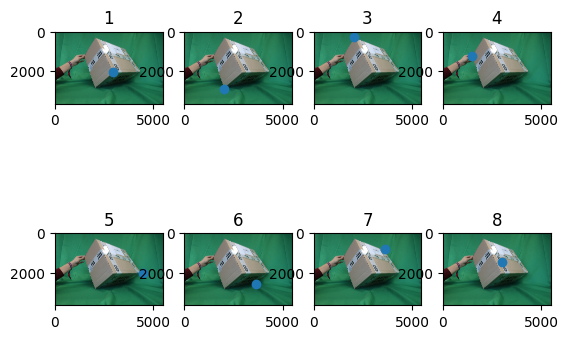

In [20]:
for i, p in enumerate(Final_list_order[1:]):
     plt.subplot(2,4,i+1)
     plt.imshow(m_img)
     plt.scatter(p[0], p[1], cmap='b')
     plt.title(f"{i+1}")
plt.show()


[[2994, 2013], [2946, 1588], [2027, 763], [2051, 3393], [1470, 2402], [4456, 1639], [3627, 1087], [3627, 2831], [3015, 2202]]


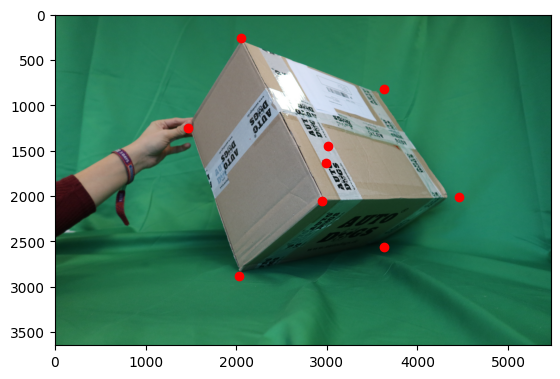

In [23]:
# extract side of parcel: 

with open(data_root+"ford/order_val_size_correct.json", 'r') as f:
    data=json.load(f)
    

test_dict=data[39]
m_img=plt.imread(img_root+test_dict["image_name"])
h, w, c=m_img.shape
plt.imshow(m_img)


m_points=test_dict["points"]
print(m_points)
for p in m_points:
    plt.plot(p[0],h-p[1], 'ro')
plt.show()

